# LS Lidar PCD'S Detection using YoloV4 Complex
In this notebook you will be able to classify point cloud data into Car/Pedestrian Classes.


## First we will import the libraries that we will use to run the below code.

In [12]:
addpath('C:\Users\abdel\Downloads\Scripts and Trained mat files-1\Functions');
addpath("C:\Users\abdel\Downloads\iou_script_ammad")


## Loading the Trained Model

In this section, we load a previously trained model along with its essential components for object detection from LiDAR data. The process involves several steps:

1. **Loading the Model File**: We start by loading the `.mat` file containing the trained model and its parameters. This file is the result of a comprehensive training process that teaches the model to identify specific objects, such as cars and pedestrians, from LiDAR data.

    ```matlab
    mdl = load("C:\\Users\\abdel\\Downloads\\Scripts and Trained mat files-1\\lslidar_net.mat");
    ```

    It's important to note that double backslashes (`\\`) are used in file paths to ensure compatibility across different operating systems and to escape the backslash character, which has a special meaning in many programming contexts.

2. **Extracting the Model and Its Parameters**: Once the model file is loaded, we extract the trained neural network (`net`), the parameters defining the grid space (`gridParams`), and the anchor boxes (`anchors`). These elements are critical for the detection process:

    - The **neural network** (`net`) is the core of the model, capable of processing the input data (in this case, LiDAR data) and making predictions about where objects are located.
  
    - **Grid parameters** (`gridParams`) define the spatial organization of the data that the network expects. These parameters are essential for preprocessing the input data and interpreting the model's output correctly.

    - **Anchor boxes** (`anchors`) are predefined boxes that help the model detect objects of various shapes and sizes by providing reference points and dimensions.

    ```matlab
    mdl = mdl.trainedModel;
    net = mdl.net;
    gridParams = mdl.gridParams;
    anchors = mdl.anchorBoxes;
    ```

This preparatory step is crucial for setting up the object detection workflow. It ensures that all necessary components of the trained model are loaded and ready to be utilized for analyzing LiDAR data and detecting objects.


In [1]:
%% Load the Trained Model
mdl = load("C:\Users\abdel\Downloads\Scripts and Trained mat files-1\lslidar_net.mat");
mdl = mdl.trainedModel;
net = mdl.net;
gridParams = mdl.gridParams;
anchors = mdl.anchorBoxes;


Array indices must be positive integers or logical values.
Error using dlnetwork
Dot indexing is not supported for variables of this type.

Error in dlnetwork.loadobj (line 992)
                    net = dlnetwork(in.LayerGraph, exampleInputs{:}, 'Initialize', in.Initialized);



In [14]:
%% Load test point cloud
classNames = {'Car'
              'Pedestrain'};

ptCldLoc = "D:\PCDs\03_cars_cut_out\ls lidar\GetLidarDataType_LS_2023-11-01-00-13-20-089_54.pcd";
ptCld = pcread(ptCldLoc);

[img,] = preprocess(ptCld, gridParams);

## RESULTS
The results derived from testing the predictive model illustrate enhanced detection performance for vehicles relative to pedestrian predictions. Accuracy in a bird's-eye view was quantified using Average Orientation Similarity (AOS) and Average Precision (AP) metrics, whereas three-dimensional space accuracy was gauged through the Intersection over Union (IoU) metric.

## AOS AND AP RESUTLS

The YOLOv4 complex model demonstrated a high level of accuracy in object detection, as evaluated using metrics from the Computer Vision Toolbox in MATLAB. The Average Orientation Similarity (AOS) and Average Precision (AP) were key metrics used for this evaluation. AOS assesses the performance based on the detection of rotated rectangles, indicating the model's precision and recall capabilities. AP is a widely accepted measure of detector performance. These metrics were applied after training the network, comparing test data with predicted data to ascertain accuracy. The model showed high accuracy for the 'Car' class in terms of both orientation and classification, suggesting strong vehicle detection capabilities. However, it scored lower for the 'Pedestrian' class, indicating difficulties in detecting smaller, non-vehicular objects due to challenges such as size, movement patterns, and LiDAR point density. This presents an area for improvement, particularly in enhancing pedestrian detection by training the model with more varied pedestrian data and movement patterns.

| Class      | AOS     | AP      |
|------------|---------|---------|
| Car        | 0.78957 | 0.79028 |
| Pedestrian | 0.23154 | 0.23154 |

As shown in Table above AOS value for the ’Car’ class is 0.78957 and an AP value of
0.79028 which means that the network is able to classify cars with high accuracy and
accurately predicting their orientation. These metrics suggest a strong capability of the
model in scenarios involving vehicle detection.
Performance on ’Pedestrian’ Class: In contrast, the lower scores for the ’Pedestrian’
class signal challenges in detecting smaller, non-vehicular objects. This could be attributed to factors like smaller size, varied movement patterns, and lower point density
in LiDAR data for pedestrians. This finding highlights a potential area for improvement
in the model’s capability to handle diverse object types.


## Model Predictions Results

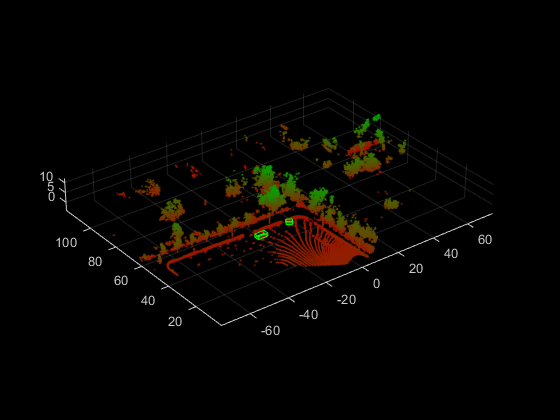

In [15]:
%% Detect objects in test image BEV
executionEnvironment = 'auto';
[bboxes, scores, labels] = detectComplexYOLOv4(net, img, anchors, classNames, executionEnvironment);

% BEV Detection
try
    % Display the output.
    helperDisplayBoxes(img,bboxes,labels);
catch
    warning('No Objects Detected!');
end

% 3D PCD 
try
    % Transferring bbox to point cloud
    [ptCldOut,bboxCuboid] = transferbboxToPointCloud(bboxes,gridParams,ptCld);
    helperDisplayBoxes(ptCldOut,bboxCuboid,labels);
catch
    warning('No Objects Detected!');
end

In the above figure, the model has predicted 2 objects of class 'car'.


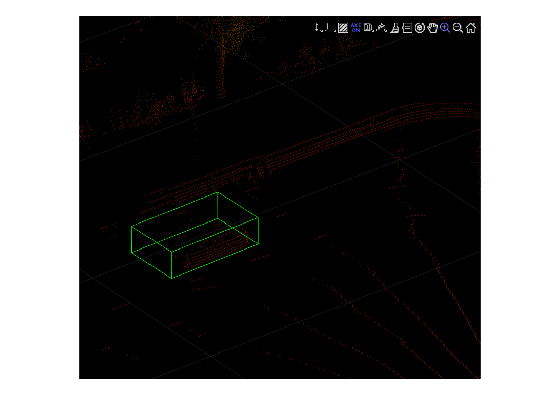

In [19]:
imagePath = 'C:/Users/abdel/Downloads/ls_detected_carpng.png'; % Forward slashes

% Display the image
imshow(imagePath)

In the above figure, a close-up image of a detected car is shown.







## Testing the accuracy using Intersection Over Union (IoU)

First, we define an IoU threshold to categorize detections as successful or not. We then initialize arrays to store the IoU values for detections classified as 'car' and 'human'. Arrays for false detections (IoU below threshold) are also initialized. This setup helps in evaluating the performance of our object detection model.


In [20]:
% Loading The predicted and the actual Labels to compare them
iouThreshold = 0;
loadedData = load("C:\Users\abdel\Downloads\Gtruth(labelled@Predicted)\Tconcat.mat"); % Loading the Original gTruth labels
loadedDataa = load("C:\Users\abdel\Downloads\Gtruth(labelled@Predicted)\original.mat"); % Loading the Predicted gTruth labels
original=loadedDataa.original; % Predicted gTruth
Tconcat = loadedData.Tconcat;  % Test Data

timestamps = Tconcat.Time;
numTimestamps = numel(timestamps);

% Initialize arrays to store individual IoU values for 'car' and 'human'
iouValuesCar = NaN(numTimestamps, 1); % Using NaN to easily identify timestamps without IoU calculations
iouValuesHuman = NaN(numTimestamps, 1); % Same for the 'human' class
iouValuesCarFalse = NaN(numTimestamps, 1); 
iouValuesHumanFalse = NaN(numTimestamps, 1);


## Calculate IoU Values

In this section, we iterate through our detections and the corresponding ground truth to calculate the IoU for each detected object. The IoU values are stored separately for 'car' and 'human' classes, allowing us to analyze the model's performance in detecting each class.


In [21]:
for i = 1:height(Tconcat)
    % Calculate IoU for 'car' class and store the value
    if ~isempty(Tconcat.car{i}) && ~isempty(original.car{i})
        iouCar = calculate3DIoU(Tconcat.car{i}, original.car{i});
        if iouCar > iouThreshold
            iouValuesCar(i) = iouCar; % Store the IoU value
        else
            iouValuesCarFalse(i)=iouCar;
        end
    end

    % Calculate IoU for 'human' class and store the value
    if ~isempty(Tconcat.human{i}) && ~isempty(original.human{i})
        iouHuman = calculate3DIoU(Tconcat.human{i}, original.human{i});
        if iouHuman > iouThreshold
            iouValuesHuman(i) = iouHuman; % Store the IoU value
        else
            iouValuesHumanFalse(i)= iouHuman;
        end
    end
end


## Analyze IoU Values by Scene

Intersection over Union (IOU) is a metric used to evaluate the accuracy of an object detector on a particular dataset. Specifically, it measures the overlap between the predicted bounding box and the ground truth bounding box. An IOU score ranges from 0 to 1, where 1 indicates a perfect match between the predicted and actual bounding boxes, and 0 indicates no overlap. In the context of these figures, the IOU values provide insight into how closely the model's predictions for cars and pedestrians align with their actual locations in the images. Higher IOU values suggest better model performance in accurately identifying and locating objects.

We segment the calculated IoU values based on specific scenes from the LiDAR dataset. This segmentation allows for a detailed analysis of the detection performance across different parts of the dataset.


In [22]:
% LS Lidar Scene 1 Car #Change 1087 etc.
iouCars_1 = iouValuesCar(1:1087, :);
iouCars_1 = iouCars_1(~any(isnan(iouCars_1), 2), :);


% LS Lidar Scene 2 Car
iouCars_2 = iouValuesCar(1088:2159, :);
iouCars_2 = iouCars_2(~any(isnan(iouCars_2), 2), :);

% LS Lidar Scene 3 Car
iouCars_3 = iouValuesCar(2160:2739, :);
iouCars_3 = iouCars_3(~any(isnan(iouCars_3), 2), :);

% LS Lidar Scene 4 Car
iouCars_4 = iouValuesHuman(2740:3257, :);
iouCars_4 = iouCars_4(~any(isnan(iouCars_4), 2), :);

% LS Lidar Scene 5 Human
iouCars_5 = iouValuesHuman(3258:4063, :);
iouCars_5 = iouCars_5(~any(isnan(iouCars_5), 2), :);

% LS Lidar Scene 6 Human
iouCars_6 = iouValuesHuman(4064:4787, :);
iouCars_6 = iouCars_6(~any(isnan(iouCars_6), 2), :);

## Plotting IoU Values

To visualize the performance, we plot the IoU values for the first scene. The plot includes both the raw IoU values and a smoothed version using a Savitzky-Golay filter, offering insights into the model's consistency in object detection over time.


Note that Figures 1, 2, and 3 show IOU values for cars (predicted compared to actual), and Figures 4, 5, and 6 show predicted pedestrians compared to actual labels.


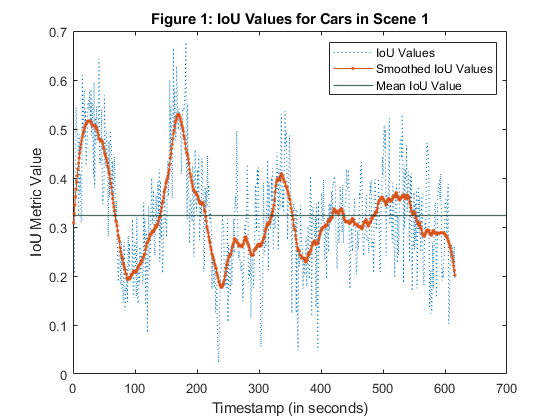

In [33]:
% For plotting scene 1
order = 3;
framelen = 55;

sgf = sgolayfilt(iouCars_1,order,framelen);
meanValue = mean(iouCars_1);
plot(iouCars_1,':')
hold on
plot(sgf,'.-')
yline(meanValue, 'Color', '#013220', 'LineWidth', 1)
legend('IoU Values','Smoothed IoU Values', 'Mean IoU Value')
xlabel('Timestamp (in seconds)')
ylabel('IoU Metric Value')
title('Figure 1: IoU Values for Cars in Scene 1')


IoU graph 1: Intersection comparison of labelled and predicted bounding boxes for Scene 1.

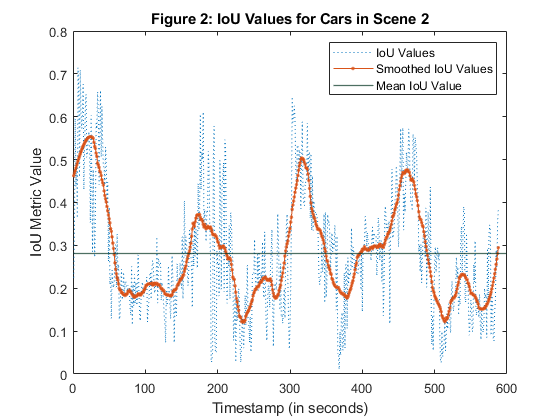

In [34]:
% For plotting scene 2
order = 3;
framelen = 55;

sgf = sgolayfilt(iouCars_2,order,framelen);
meanValue = mean(iouCars_2);
plot(iouCars_2,':')
hold on
plot(sgf,'.-')
yline(meanValue, 'Color', '#013220', 'LineWidth', 1)
legend('IoU Values','Smoothed IoU Values', 'Mean IoU Value')
xlabel('Timestamp (in seconds)')
ylabel('IoU Metric Value')
title('Figure 2: IoU Values for Cars in Scene 2')


IoU graph 2: Intersection com-parison of labelled and predicted bounding boxes for Scene 2.


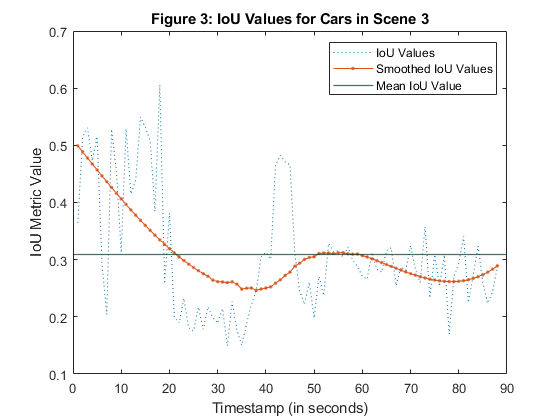

In [35]:
% For plotting scene 3
order = 3;
framelen = 55;

sgf = sgolayfilt(iouCars_3,order,framelen);
meanValue = mean(iouCars_3);
plot(iouCars_3,':')
hold on
plot(sgf,'.-')
yline(meanValue, 'Color', '#013220', 'LineWidth', 1)
legend('IoU Values','Smoothed IoU Values', 'Mean IoU Value')
xlabel('Timestamp (in seconds)')
ylabel('IoU Metric Value')
title('Figure 3: IoU Values for Cars in Scene 3')


IoU graph 3: Intersection com-parison of labelled and predicted bounding boxes for Scene 3.


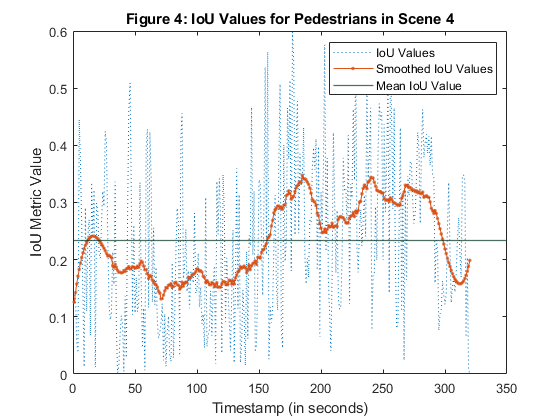

In [36]:
% For plotting scene 4
order = 3;
framelen = 55;

sgf = sgolayfilt(iouCars_4,order,framelen);
meanValue = mean(iouCars_4);
plot(iouCars_4,':')
hold on
plot(sgf,'.-')
yline(meanValue, 'Color', '#013220', 'LineWidth', 1)
legend('IoU Values','Smoothed IoU Values', 'Mean IoU Value')
xlabel('Timestamp (in seconds)')
ylabel('IoU Metric Value')
title('Figure 4: IoU Values for Pedestrians in Scene 4')



IoU graph 4: Intersection com-parison of labelled and predicted bounding boxes for Scene 4.

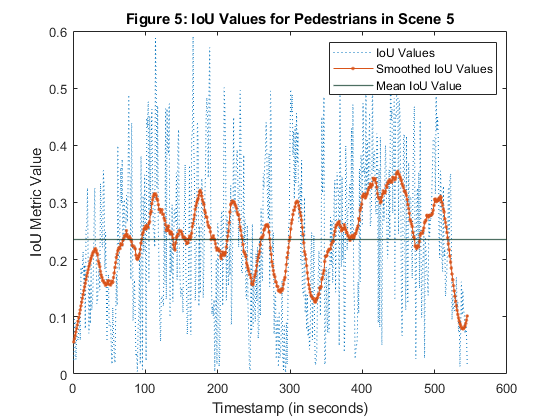

In [37]:
% For plotting scene 1
order = 3;
framelen = 55;

sgf = sgolayfilt(iouCars_5,order,framelen);
meanValue = mean(iouCars_5);
plot(iouCars_5,':')
hold on
plot(sgf,'.-')
yline(meanValue, 'Color', '#013220', 'LineWidth', 1)
legend('IoU Values','Smoothed IoU Values', 'Mean IoU Value')
xlabel('Timestamp (in seconds)')
ylabel('IoU Metric Value')
title('Figure 5: IoU Values for Pedestrians in Scene 5')


IoU graph 5: Intersection com-parison of labelled and predicted bounding boxes for Scene 5.

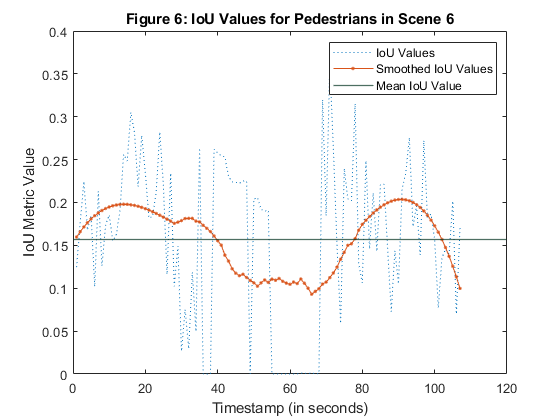

In [38]:
% For plotting scene 6
order = 3;
framelen = 55;

sgf = sgolayfilt(iouCars_6,order,framelen);
meanValue = mean(iouCars_6);
plot(iouCars_6,':')
hold on
plot(sgf,'.-')
yline(meanValue, 'Color', '#013220', 'LineWidth', 1)
legend('IoU Values','Smoothed IoU Values', 'Mean IoU Value')
xlabel('Timestamp (in seconds)')
ylabel('IoU Metric Value')
title('Figure 6: IoU Values for Pedestrians in Scene 6')


IoU graph 6: Intersection com-parison of labelled and predicted bounding boxes for Scene 6.


## Calculate and Display Detection Accuracy

Finally, we calculate the detection accuracy for 'car' and 'human' classes based on the IoU values. This metric helps quantify the model's effectiveness in correctly identifying each class within the LiDAR data.


In [43]:
% Calculate the accuracy for 'car'
totalDetectionsCar = sum(~isnan(iouValuesCar)) + sum(~isnan(iouValuesCarFalse)); % Total detections
successfulDetectionsCar = sum(~isnan(iouValuesCar)); % Successful detections
accuracyCar = successfulDetectionsCar / totalDetectionsCar;
totalDetectionsHuman = sum(~isnan(iouValuesHuman)) + sum(~isnan(iouValuesHumanFalse)); % Total detections
successfulDetectionsCar = sum(~isnan(iouValuesHuman)); % Successful detections
accuracyHuman = successfulDetectionsCar / totalDetectionsCar;
accuracyCar
accuracyHuman



accuracyCar =

    0.7520


accuracyHuman =

    0.5658




## Conclusion
In conclusion, the integration of the YOLOv4 Complex model with labeled data from the LS LiDAR has yielded commendable results in vehicle detection, though it demonstrated reduced efficacy in identifying pedestrians. This discrepancy has unveiled significant insights into enhancing the model's precision, particularly concerning pedestrian and small object detection.

Looking ahead, the primary aim for future research is to elevate the model's detection accuracy. Such advancements are anticipated through the acquisition of an extensive dataset, especially from environments featuring a diverse array of objects. Furthermore, proposed modifications and enhancements to the neural network's layers are expected to refine the model's capability to discern and process varied data patterns more effectively. These initiatives are poised to augment the accuracy of object detection, marking a pivotal step towards realizing more reliable and efficient autonomous systems.